<a href="https://colab.research.google.com/github/catlaughing/Malaria-Cell-Classification/blob/master/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Import it first so that we can restart the runtime if colab imported the wrong version ##
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)

In [0]:
## IMPORT EVERYTHING ##
from torchvision import datasets,models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

0.4.1


In [0]:
## Get the dataset Ready ##

# Install Kaggle and make directory for kaggle
!pip install -U -q kaggle && mkdir -p ~/.kaggle

# move json file from kaggle to the kaggle directory
cp kaggle.json ~/.kaggle/

# Download the dataset
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria && unzip cell-images-for-detecting-malaria -d data/

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img_compose = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    pil_img = PIL.Image.open(image)
    img = img_compose(pil_img)
    
    
    return img

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [0]:
def save_model(model,epoch,optimizer):
    '''
    Save the model
    '''
    model.class_to_idx = dataset.class_to_idx
    state = {
          'epoch': epoch,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(),
          'class_to_idx': model.class_to_idx
        }
    torch.save(state, 'model_Malaria.pt')

In [0]:
def load_model():
    '''
    Load the model
    '''
    state = torch.load('model_Malaria.pt')
    model.load_state_dict(state['state_dict'])
    optim.load_state_dict(state['optimizer'])
    model.class_to_idx = state['class_to_idx']
    return model,optim

In [0]:
# Load The Data #
dataset = datasets.ImageFolder('data/cell_images')

In [0]:
# Split the data to 3 parts #
n = len(dataset)
n_train = int(n * 0.5)+1
n_val = n_test = int(n*0.25)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, (n_train, n_val, n_test))

In [0]:
# Define the tranform #
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [0]:
# Transform the dataset #
train_set.dataset.transform = train_transforms
val_set.dataset.transform = valid_transforms
test_set.dataset.transform = valid_transforms

In [0]:
# Make the dataset Loadet #
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)

In [0]:
# Define the class #
classes = ['Parasitized','Uninfected']

torch.Size([3, 224, 224])


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


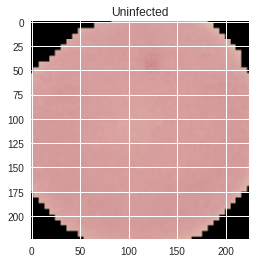

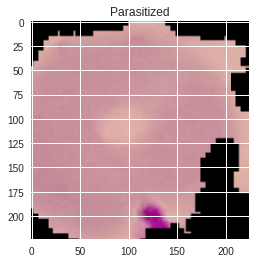

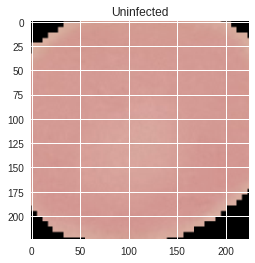

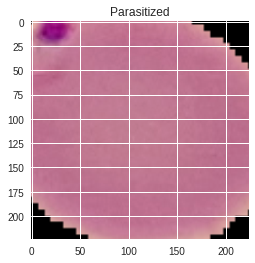

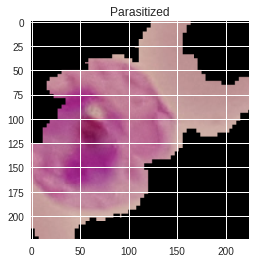

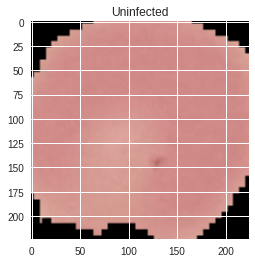

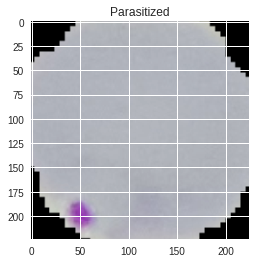

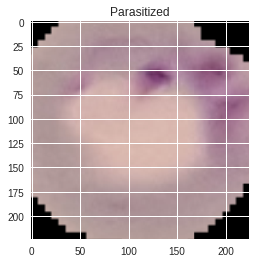

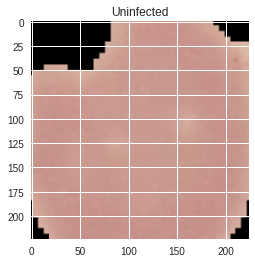

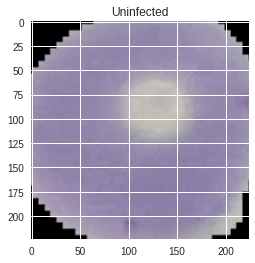

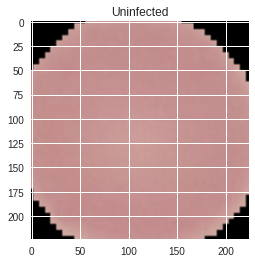

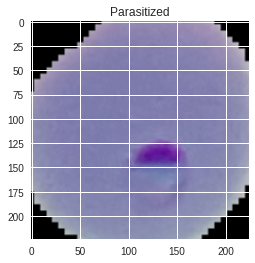

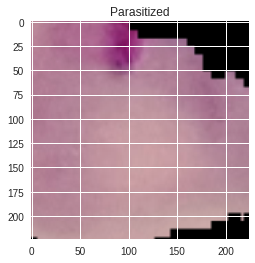

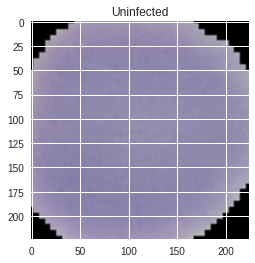

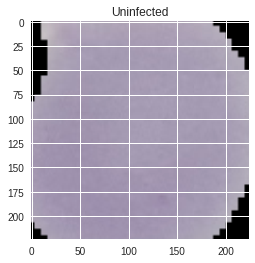

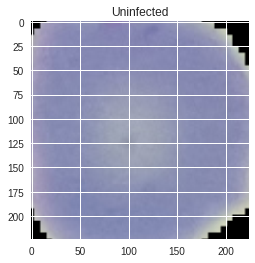

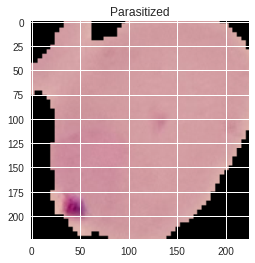

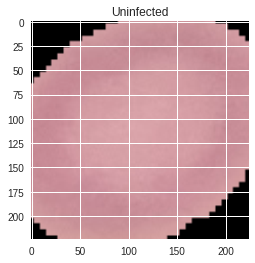

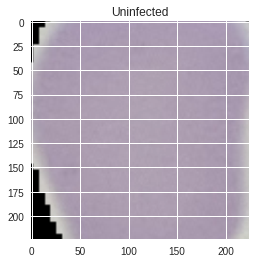

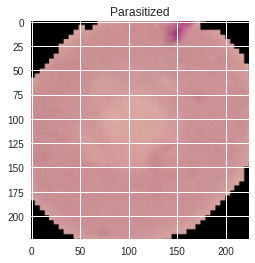

In [0]:
##########################
# Visualize the data set #
##########################

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images[0].shape)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
#########################
## Construct the model ##
#########################

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        # 224*224*3
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride=2)
        # 56*56*32
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        # 14*14*32
        self.conv3 = nn.Conv2d(32,64,3, padding=1, stride=2)
        # 3*3*64
        self.conv4 = nn.Conv2d(64,64,3, padding=1, stride=2)
        # 1*1*64
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Linear layer
        self.fc1 = nn.Linear(1*1*64, 520)
        self.fc2 = nn.Linear(520, 256)
        self.fc3 = nn.Linear(256,1)
        
        # Activation
        self.sigmoid = nn.Sigmoid()
        
        # Dropout
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(-1, 1*1*64)
        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x


In [0]:
########################
# Initialize the model #
########################

model = Net()
model = model.cuda()
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=520, bias=True)
  (fc2): Linear(in_features=520, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.25)
)


In [0]:
# specify loss function
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

# specify lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
# number of epochs to train the model
n_epochs = 20 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss
train_on_gpu = torch.cuda.is_available()

for epoch in range(1, n_epochs+1):
    metrics.reset()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    val_accuracy = 0.0
    
    ###################
    # TRAIN THE MODEL #
    ###################
    model.train()
    i = 0
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Change the target shape
        target = target.view(-1,1)    
        if i % 32 == 0:
            print(output)
            print(target)
            i+=1
        # calculate the batch loss
        loss = criterion(output, target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # VALIDATE THE MODEL #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Change target shape
            target = target.view(-1,1)
            # calculate the batch loss
            loss = criterion(output, target.float())
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # accuracy
            preds_tensor = torch.where(output.cpu()>0.5, ones,zeros)
            pred = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
            val_accuracy += (pred == target).sum().item()
            
            
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    val_accuracy = val_accuracy/len(test_loader.dataset)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \tAccuracy: {:.6f}  '  .format(
       epoch, train_loss, valid_loss, val_accuracy))
    
    # print training/validation statistics 
#     print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
#         epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        save_model(model,epoch,optimizer)
        valid_loss_min = valid_loss

[1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 1. 1.]


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


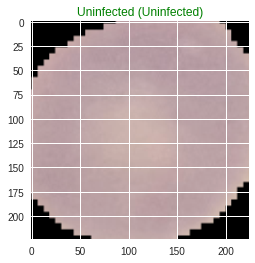

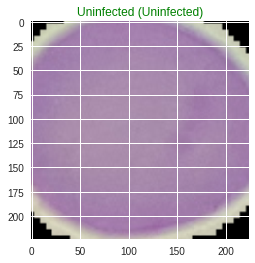

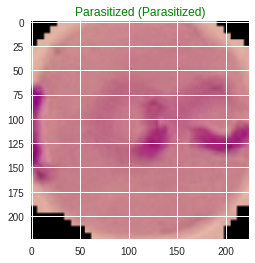

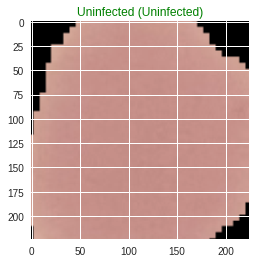

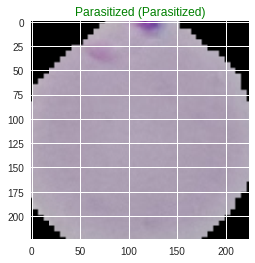

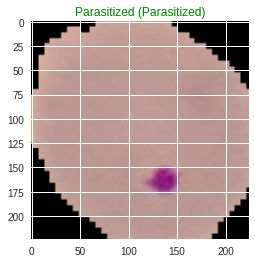

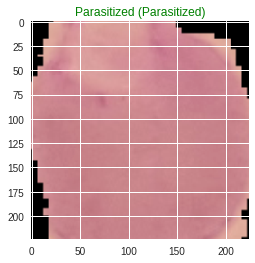

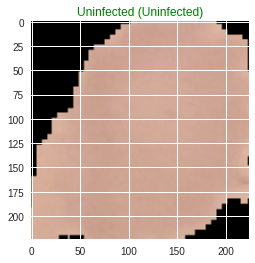

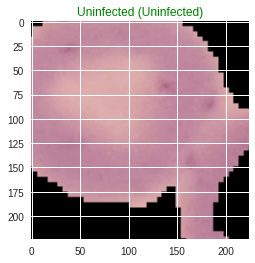

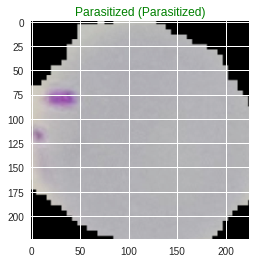

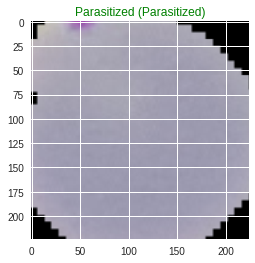

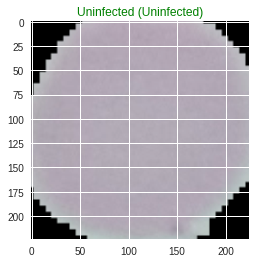

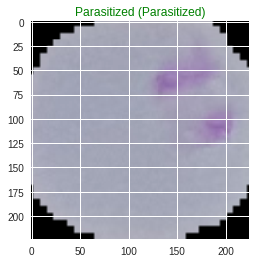

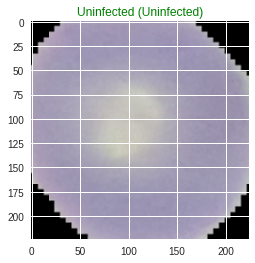

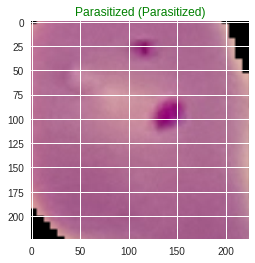

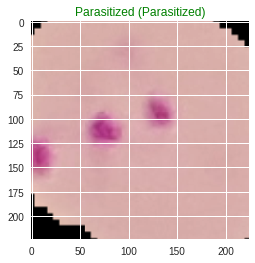

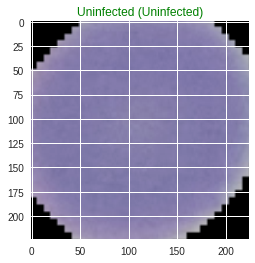

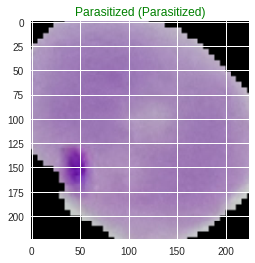

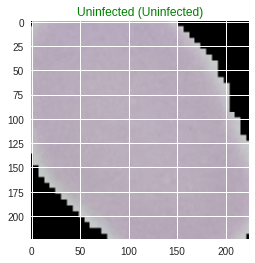

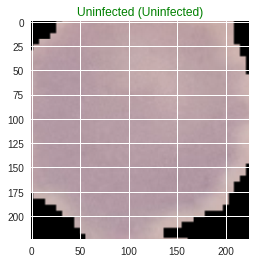

In [0]:
################    
# Sanity Check #
################

#obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)

# Make the one and zero tensor
ones = torch.ones(output.shape)
zeros = torch.zeros(output.shape)

# convert output probabilities to predicted class
preds_tensor = torch.where(output.cpu()>0.5, ones,zeros)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = imshow(images[idx].cpu().numpy())
    ax.set_title("{} ({})".format(classes[int(preds[idx])], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [0]:
#####################    
# TESTING THE MODEL #
#####################

model.eval()
correct = count = 0
all_pred = []
all_pred = all_target = np.array(all_pred)
with torch.no_grad():
    i = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        
        output = model(data)
        ones = torch.ones(output.shape)
        zeros = torch.zeros(output.shape)
        preds_tensor = torch.where(output.cpu()>0.5, ones,zeros)
        pred = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
        
        count += data.size(0)
        correct += (pred == target).sum().item()
        
        all_pred = np.append(all_pred,preds_tensor)
        all_target = np.append(all_target,target)
        i+=1

print(f'Accurately classified {(100 * correct // count):d}% of {count} images.')

[1. 1. 0. ... 1. 0. 1.]
[1. 1. 0. ... 1. 1. 1.]
Accurately classified 89% of 6889 images.


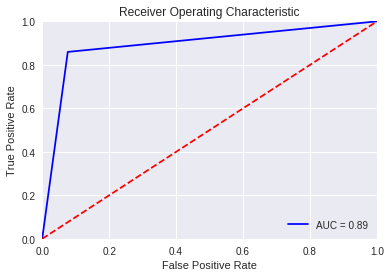

              precision    recall  f1-score   support

 Parasitized       0.87      0.92      0.89      3416
  Uninfected       0.92      0.86      0.89      3473

   micro avg       0.89      0.89      0.89      6889
   macro avg       0.89      0.89      0.89      6889
weighted avg       0.89      0.89      0.89      6889



In [0]:
#########################
# CLASSIFICATION REPORT #
#########################

## Convert the np array from float to int for the report ##
all_target = all_target.astype(int)
all_pred = all_pred.astype(int)

# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(all_target, all_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(metrics.classification_report(all_target,all_pred,target_names=classes))